In [1]:
#import the required libraries
%matplotlib notebook

import pandas as pd
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point, LineString, Polygon
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import cartopy as cp
from cartopy import config
from cartopy.feature import ShapelyFeature
import cartopy.crs as ccrs
import contextily as ctx
import seaborn as sns

In [2]:
plt.ion() # make the plotting interactive

# generate matplotlib handles to create a legend of the features we put in our map.
def generate_handles(labels, colors, edge='k', alpha=1):
    lc = len(colors)  # get the length of the color list
    handles = []
    for i in range(len(labels)):
        handles.append(mpatches.Rectangle((0, 0), 1, 1, facecolor=colors[i % lc], edgecolor=edge, alpha=alpha))
    return handles

# create a scale bar of length 20 km in the upper right corner of the map
# adapted this question: https://stackoverflow.com/q/32333870
# answered by SO user Siyh: https://stackoverflow.com/a/35705477
def scale_bar(ax, location=(0.92, 0.95)):
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]

    tmc = ccrs.TransverseMercator(sbllx, sblly)
    x0, x1, y0, y1 = ax.get_extent(tmc)
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    plt.plot([sbx, sbx - 20000], [sby, sby], color='k', linewidth=9, transform=tmc)
    plt.plot([sbx, sbx - 10000], [sby, sby], color='k', linewidth=6, transform=tmc)
    plt.plot([sbx-10000, sbx - 20000], [sby, sby], color='w', linewidth=6, transform=tmc)

    plt.text(sbx, sby-4500, '20 km', transform=tmc, fontsize=10)
    plt.text(sbx-12500, sby-4500, '10 km', transform=tmc, fontsize=10)
    plt.text(sbx-24500, sby-4500, '0 km', transform=tmc, fontsize=10)

In [3]:
#Read radon data of the Northern Ireland
radon_table = pd.read_csv('data_files\RadonNI.csv')

In [4]:
radon_table.shape # dispaly the data structure: 14720 rows and 4 columns

(14720, 4)

In [5]:
radon_table.info() # More information about the data: 14720 entries, position from 0 to 14719 arranged in 4 columns
                    # first column is object format, while the other three are in integre formats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14720 entries, 0 to 14719
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tile    14720 non-null  object
 1   class   14720 non-null  int64 
 2   x       14720 non-null  int64 
 3   y       14720 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 460.1+ KB


In [6]:
radon_table["class"]

0        1
1        1
2        1
3        2
4        2
        ..
14715    5
14716    4
14717    4
14718    4
14719    4
Name: class, Length: 14720, dtype: int64

In [7]:
radon_table.head(10) #show the top 10 rows with the column headings

,Tile,class,x,y
0,D1053,1,310500,453500
1,D1153,1,311500,453500
2,D1253,1,312500,453500
3,D0952,2,309500,452500
4,D1052,2,310500,452500
5,D1152,2,311500,452500
6,D1252,2,312500,452500
7,D1352,2,313500,452500
8,D1452,2,314500,452500
9,D1552,1,315500,452500


In [8]:
# summary statistics
radon_table.describe()

,class,x,y
count,14720.000000,14720.000000,14720.000000
mean,2.682541,284638.111413,373938.383152
std,1.541938,41306.305800,32692.536830
min,1.000000,188500.000000,309500.000000
25%,1.000000,250500.000000,347500.000000
50%,2.000000,288500.000000,370500.000000
75%,4.000000,318500.000000,399500.000000
max,6.000000,366500.000000,453500.000000


In [9]:
radon_table['class'].describe().round(0) # descriptive statistics of the radon classes, round numbers to nearest integer.

count    14720.0
mean         3.0
std          2.0
min          1.0
25%          1.0
50%          2.0
75%          4.0
max          6.0
Name: class, dtype: float64

<IPython.core.display.Javascript object>


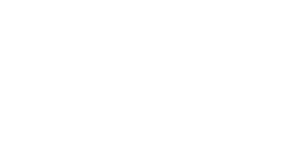

In [10]:
radon_table.hist(column='class', bins=[0.5,1.5,2.5,3.5,4.5,5.5,6.5]);

C:\Users\asuwa\anaconda3\envs\RadonNI\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


<IPython.core.display.Javascript object>


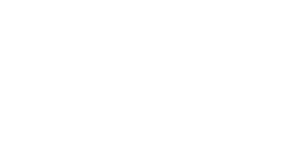

In [11]:
# set the coordinate type (to epsg:29902) and plot the radon data with respect to x, y
pts = [Point(row['x'], row['y']) for id, row in radon_table[['x', 'y']].iterrows()]
pts = gpd.GeoSeries(pts, crs='+init=epsg:29902')
pts.plot();

In [12]:
pts.crs # check the coordinate systems

<Projected CRS: EPSG:29902>
Name: TM65 / Irish Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore.
- bounds: (-10.56, 51.39, -5.93, 55.43)
Coordinate Operation:
- name: Irish Grid
- method: Transverse Mercator
Datum: TM65
- Ellipsoid: Airy Modified 1849
- Prime Meridian: Greenwich

In [13]:
# another way to assign the coordinate system.
radon_gdf = gpd.GeoDataFrame(radon_table, geometry=gpd.points_from_xy(radon_table.x, radon_table.y), crs='+init=epsg:29902')

C:\Users\asuwa\anaconda3\envs\RadonNI\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [14]:
radon_gdf.crs # check the coordinate system of the new dataset (radon_gdf)

<Projected CRS: EPSG:29902>
Name: TM65 / Irish Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore.
- bounds: (-10.56, 51.39, -5.93, 55.43)
Coordinate Operation:
- name: Irish Grid
- method: Transverse Mercator
Datum: TM65
- Ellipsoid: Airy Modified 1849
- Prime Meridian: Greenwich

In [15]:
radon_gdf.to_file('data_files/RadonNI.shp') # create a new shapefile of the radon data

In [16]:
radon = gpd.read_file('data_files/RadonNI.shp') # load the radon shapefile

<IPython.core.display.Javascript object>


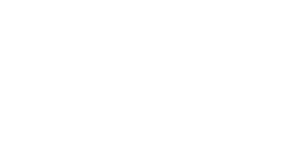

In [17]:
# Display the radon distribution
fig, ax = plt.subplots(figsize=(15, 15))

radon.plot(column='class',
                categorical=True,
                legend=True,
                ax=ax)

# Adjust legend location
leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15,0.5))

ax.set_axis_off()

plt.show()

Now, we need to load the Northern Ireland Counties map (shapefile)

In [18]:
counties_orig = gpd.read_file('data_files/Counties.shp') # load the Counties shapefile

In [19]:
counties_orig.shape # Table of attributes is made up of 6 rows and five columns

(6, 5)

In [20]:
counties_orig.columns # read the column headings

Index(['COUNTY_ID', 'CountyName', 'Area_SqKM', 'OBJECTID', 'geometry'], dtype='object')

In [21]:
divisions = counties_orig['CountyName'].tolist() # Get a list of a the counties; 6 counties
print(divisions)

['TYRONE', 'ANTRIM', 'ARMAGH', 'FERMANAGH', 'LONDONDERRY', 'DOWN']


In [22]:
# display the data. 
# Note that each county is represented by one polygon while county Antrim is represnted by more than one polygon (due to the presence of Rathlin ireland in the north)
counties_orig.head()

,COUNTY_ID,CountyName,Area_SqKM,OBJECTID,geometry
0,6,TYRONE,3265.796622,1,"POLYGON ((-7.38177 54.94208, -7.38170 54.94201..."
1,1,ANTRIM,3097.847750,2,"MULTIPOLYGON (((-5.95296 54.55222, -5.95298 54..."
2,2,ARMAGH,1327.228438,3,"POLYGON ((-6.35398 54.50927, -6.35191 54.50891..."
3,4,FERMANAGH,1850.832538,4,"POLYGON ((-7.69417 54.60511, -7.69390 54.60498..."
4,5,LONDONDERRY,2118.316853,5,"POLYGON ((-6.66919 55.19899, -6.66918 55.19893..."


In [23]:
# sort the counties according to their area (in km2), starting with the largest.
counties_orig.groupby("CountyName").mean().sort_values(by = "Area_SqKM", ascending = False)

,COUNTY_ID,Area_SqKM,OBJECTID
CountyName,,,
TYRONE,6,3265.796622,1
ANTRIM,1,3097.847750,2
DOWN,3,2491.238606,6
LONDONDERRY,5,2118.316853,5
FERMANAGH,4,1850.832538,4
ARMAGH,2,1327.228438,3


<IPython.core.display.Javascript object>


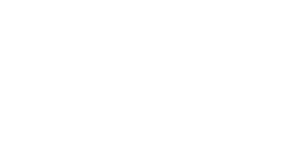

C:\Users\asuwa\anaconda3\envs\RadonNI\lib\site-packages\contextily\tile.py:632: UserWarning: The inferred zoom level of 26 is not valid for the current tile provider (valid zooms: 0 - 18).
  warnings.warn(msg)


In [24]:
# to show a basemap background
f, ax = plt.subplots(1, figsize=(9, 9), edgecolor="blue", facecolor="yellow")
counties_orig.plot(color='k', alpha=0.5, ax=ax)
ctx.add_basemap(ax)
plt.show('CountyName')
f.suptitle('Northern Ireland Administrative divisions')
plt.show()

<IPython.core.display.Javascript object>


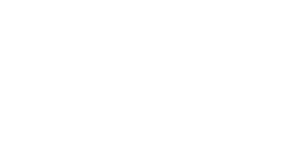

In [25]:
counties_orig.plot(figsize=(10,10), edgecolor="purple", facecolor="None"); # plot the counties in the Northern Ireland

<IPython.core.display.Javascript object>


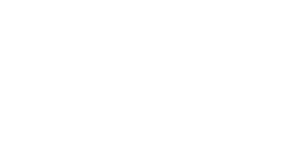

In [26]:
counties_orig.plot('CountyName', legend=True, figsize=(10, 10)); # add symbologies and legend to the counties map

In [27]:
counties_orig.crs # check the coordinate system of the counties shapefile

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
counties = counties_orig.to_crs(epsg=29902) # change the CRS to epsg=29902, to match the radon data coordinates

In [29]:
counties.crs

<Projected CRS: EPSG:29902>
Name: TM65 / Irish Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore.
- bounds: (-10.56, 51.39, -5.93, 55.43)
Coordinate Operation:
- name: Irish Grid
- method: Transverse Mercator
Datum: TM65
- Ellipsoid: Airy Modified 1849
- Prime Meridian: Greenwich

# Note the difference in the X, Y values above.

<IPython.core.display.Javascript object>


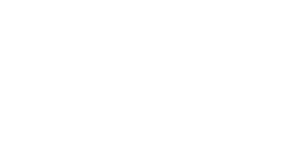

In [30]:
counties.plot('CountyName', legend=True, figsize=(10, 10)); # map again using the new CRS

In [31]:
print(radon.crs == counties.crs) # check if the CRS of the radon and counties data are the same

True


In [32]:
radon_counties = gpd.sjoin(counties, radon, how='inner', lsuffix='left', rsuffix='right')  # join the two datasets into one

In [33]:
radon_counties # display the new dataset, point datasets combining the radon and the county each point is located within

,COUNTY_ID,CountyName,Area_SqKM,OBJECTID,geometry,index_right,Tile,class,x,y
0,6,TYRONE,3265.796622,1,"POLYGON ((239669.128 410673.862, 239674.096 41...",11267,H7546,4,275500,346500
0,6,TYRONE,3265.796622,1,"POLYGON ((239669.128 410673.862, 239674.096 41...",11268,H7646,3,276500,346500
0,6,TYRONE,3265.796622,1,"POLYGON ((239669.128 410673.862, 239674.096 41...",11109,H7647,2,276500,347500
0,6,TYRONE,3265.796622,1,"POLYGON ((239669.128 410673.862, 239674.096 41...",11723,H7343,3,273500,343500
0,6,TYRONE,3265.796622,1,"POLYGON ((239669.128 410673.862, 239674.096 41...",11724,H7443,3,274500,343500
...,...,...,...,...,...,...,...,...,...,...
5,3,DOWN,2491.238606,6,"MULTIPOLYGON (((325844.568 312608.674, 325840....",8630,J2662,1,326500,362500
5,3,DOWN,2491.238606,6,"MULTIPOLYGON (((325844.568 312608.674, 325840....",8631,J2762,1,327500,362500
5,3,DOWN,2491.238606,6,"MULTIPOLYGON (((325844.568 312608.674, 325840....",8612,J0862,3,308500,362500
5,3,DOWN,2491.238606,6,"MULTIPOLYGON (((325844.568 312608.674, 325840....",8445,J0863,1,308500,363500


In [34]:
radon_counties.shape # structure of the new dataset; 13855 rows and 10 columns

(13855, 10)

In [35]:
radon_counties.info() #type of data within the new dataset

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 13855 entries, 0 to 5
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   COUNTY_ID    13855 non-null  int64   
 1   CountyName   13855 non-null  object  
 2   Area_SqKM    13855 non-null  float64 
 3   OBJECTID     13855 non-null  int64   
 4   geometry     13855 non-null  geometry
 5   index_right  13855 non-null  int64   
 6   Tile         13855 non-null  object  
 7   class        13855 non-null  int64   
 8   x            13855 non-null  int64   
 9   y            13855 non-null  int64   
dtypes: float64(1), geometry(1), int64(6), object(2)
memory usage: 1.2+ MB


<IPython.core.display.Javascript object>


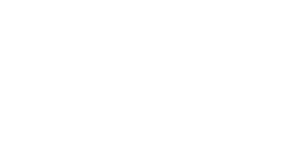

In [36]:
# distribution of various classes within the counties. Every county contian the 6 classess, except County LONDONDERRY
# adapted from: https://stackoverflow.com/questions/31594549/how-do-i-change-the-figure-size-for-a-seaborn-plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# set the size of the graph
fig.set_size_inches(12, 9)
sns.violinplot(x = "CountyName", y = "class", data = radon_counties)
#save the figure as an image
fig.savefig('Radon_classes_Counties.png')

In [37]:
# assign the CRS to the new dataset
radon_counties_gdf = gpd.GeoDataFrame(radon_counties, geometry=gpd.points_from_xy(radon_counties.x, radon_counties.y), crs='+init=epsg:29902')

C:\Users\asuwa\anaconda3\envs\RadonNI\lib\site-packages\pyproj\crs\crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [38]:
radon_counties_gdf.crs # check the CRS

<Projected CRS: EPSG:29902>
Name: TM65 / Irish Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore.
- bounds: (-10.56, 51.39, -5.93, 55.43)
Coordinate Operation:
- name: Irish Grid
- method: Transverse Mercator
Datum: TM65
- Ellipsoid: Airy Modified 1849
- Prime Meridian: Greenwich

In [39]:
radon_counties_gdf.to_file('data_files/radon_counties.shp') # create a new shapefile combining the radon and the counties data

<ipython-input-39-f73753d8efe0>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  radon_counties_gdf.to_file('data_files/radon_counties.shp') # create a new shapefile combining the radon and the counties data


In [40]:
radon_counties = gpd.read_file('data_files/radon_counties.shp') # load the radon_counties shapefile

In [41]:
radon_counties.CountyName.describe() # show a brief description of the new shapefile

count      13855
unique         6
top       TYRONE
freq        3184
Name: CountyName, dtype: object

In [42]:
radon_counties # display the attributes of the new shapefile

,COUNTY_ID,CountyName,Area_SqKM,OBJECTID,index_righ,Tile,class,x,y,geometry
0,6,TYRONE,3265.796622,1,11267,H7546,4,275500,346500,POINT (275500.000 346500.000)
1,6,TYRONE,3265.796622,1,11268,H7646,3,276500,346500,POINT (276500.000 346500.000)
2,6,TYRONE,3265.796622,1,11109,H7647,2,276500,347500,POINT (276500.000 347500.000)
3,6,TYRONE,3265.796622,1,11723,H7343,3,273500,343500,POINT (273500.000 343500.000)
4,6,TYRONE,3265.796622,1,11724,H7443,3,274500,343500,POINT (274500.000 343500.000)
...,...,...,...,...,...,...,...,...,...,...
13850,3,DOWN,2491.238606,6,8630,J2662,1,326500,362500,POINT (326500.000 362500.000)
13851,3,DOWN,2491.238606,6,8631,J2762,1,327500,362500,POINT (327500.000 362500.000)
13852,3,DOWN,2491.238606,6,8612,J0862,3,308500,362500,POINT (308500.000 362500.000)
13853,3,DOWN,2491.238606,6,8445,J0863,1,308500,363500,POINT (308500.000 363500.000)


In [43]:
radon_counties.groupby(['class']).count() # display the counts of each class

,COUNTY_ID,CountyName,Area_SqKM,OBJECTID,index_righ,Tile,x,y,geometry
class,,,,,,,,,
1,4699,4699,4699,4699,4699,4699,4699,4699,4699
2,2431,2431,2431,2431,2431,2431,2431,2431,2431
3,1721,1721,1721,1721,1721,1721,1721,1721,1721
4,2734,2734,2734,2734,2734,2734,2734,2734,2734
5,2002,2002,2002,2002,2002,2002,2002,2002,2002
6,268,268,268,268,268,268,268,268,268


In [44]:
print(radon_counties.groupby(['CountyName', 'class'])['class'].count()) # summarize the radon distribution in each County

CountyName   class
ANTRIM       1        2448
             2         397
             3           7
             4          96
             5           1
             6          11
ARMAGH       1         327
             2         434
             3         283
             4         103
             5         138
             6           3
DOWN         1         656
             2         568
             3         501
             4         331
             5         300
             6         139
FERMANAGH    1         113
             2         273
             3         349
             4         745
             5         305
             6          39
LONDONDERRY  1         964
             2         241
             3         174
             4         303
             5         422
TYRONE       1         191
             2         518
             3         407
             4        1156
             5         836
             6          76
Name: class, dtype: int64


<IPython.core.display.Javascript object>


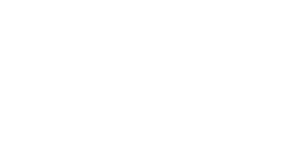

In [45]:
# Pie plot of each class count in the Northern Ireland. Class 1 is the top while class 6 is the lowest
radon_counties.groupby(['class']).count().plot(kind='pie', y='CountyName', figsize=(8, 8));

In [46]:
radon_counties.groupby("CountyName")["class"].mean()  # Average radon class in each county

CountyName
ANTRIM         1.256081
ARMAGH         2.456522
DOWN           2.786774
FERMANAGH      3.533443
LONDONDERRY    2.514259
TYRONE         3.677136
Name: class, dtype: float64

In [47]:
# Average radon class in each county, sorted by the highest. County Tyrone shows the highest radon potential risk, with an average of 3.68
radon_counties.groupby("CountyName").mean().sort_values(by = "class", ascending = False) 

,COUNTY_ID,Area_SqKM,OBJECTID,index_righ,class,x,y
CountyName,,,,,,,
TYRONE,6.0,3265.796622,1.0,7004.829774,3.677136,253130.025126,374022.613065
FERMANAGH,4.0,1850.832538,4.0,11370.660636,3.533443,223566.885965,344410.635965
DOWN,3.0,2491.238606,6.0,10890.040481,2.786774,333823.046092,347807.815631
LONDONDERRY,5.0,2118.316853,5.0,2655.370722,2.514259,273890.209125,409728.136882
ARMAGH,2.0,1327.228438,3.0,12102.815217,2.456522,294173.913043,339005.434783
ANTRIM,1.0,3097.847750,2.0,3355.223986,1.256081,316042.567568,405103.378378


Note that County Tyrone is the largest in area, also display the highest average radon potential risk.
Hence, we will focus on this county for a bit of time to understand the radon distribution in this specific county

In [48]:
# subset the data, i.e. create a new dataset representing the radon distribution in the County Tyrone
county_tyrone = radon_counties[radon_counties.CountyName == "TYRONE"]
len(county_tyrone) # returns the number of radon data (data count) in county Tyrone

3184

In [49]:
county_tyrone # display the Tyrone dataset

,COUNTY_ID,CountyName,Area_SqKM,OBJECTID,index_righ,Tile,class,x,y,geometry
0,6,TYRONE,3265.796622,1,11267,H7546,4,275500,346500,POINT (275500.000 346500.000)
1,6,TYRONE,3265.796622,1,11268,H7646,3,276500,346500,POINT (276500.000 346500.000)
2,6,TYRONE,3265.796622,1,11109,H7647,2,276500,347500,POINT (276500.000 347500.000)
3,6,TYRONE,3265.796622,1,11723,H7343,3,273500,343500,POINT (273500.000 343500.000)
4,6,TYRONE,3265.796622,1,11724,H7443,3,274500,343500,POINT (274500.000 343500.000)
...,...,...,...,...,...,...,...,...,...,...
3179,6,TYRONE,3265.796622,1,2414,C3910,4,239500,410500,POINT (239500.000 410500.000)
3180,6,TYRONE,3265.796622,1,2411,C3610,4,236500,410500,POINT (236500.000 410500.000)
3181,6,TYRONE,3265.796622,1,2412,C3710,4,237500,410500,POINT (237500.000 410500.000)
3182,6,TYRONE,3265.796622,1,2725,C4307,5,243500,407500,POINT (243500.000 407500.000)


<IPython.core.display.Javascript object>


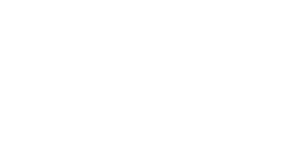

In [50]:
county_tyrone.plot(column='class', cmap=None, legend=True, figsize=(20, 20)); #plot the radon distribution in County Tyrone

In [51]:
county_tyrone.loc[[county_tyrone["class"].idxmax(), county_tyrone["class"].idxmin()]] # show the maximum and minimum class values

,COUNTY_ID,CountyName,Area_SqKM,OBJECTID,index_righ,Tile,class,x,y,geometry
413,6,TYRONE,3265.796622,1,6873,H8474,6,284500,374500,POINT (284500.000 374500.000)
81,6,TYRONE,3265.796622,1,10280,H7952,1,279500,352500,POINT (279500.000 352500.000)


In [52]:
# calculate the class percentages relative to the total area of the county. Note that County Tyrone area = 3265.796622
tyrone_class_percent = (county_tyrone.groupby(['class'])['class'].count() * 100 / 3265.796622) 
tyrone_class_percent

class
1     5.848496
2    15.861367
3    12.462503
4    35.397183
5    25.598655
6     2.327150
Name: class, dtype: float64

In [53]:
# plot the classes. Note that Class 4 is the highest in the county
ax = tyrone_class_percent.plot.bar(x='lab', y='val', rot=0)

In [54]:
county_tyrone.crs #check CRS

<Projected CRS: EPSG:29902>
Name: TM65 / Irish Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore.
- bounds: (-10.56, 51.39, -5.93, 55.43)
Coordinate Operation:
- name: Irish Grid
- method: Transverse Mercator
Datum: TM65
- Ellipsoid: Airy Modified 1849
- Prime Meridian: Greenwich

In [55]:
county_tyrone.to_file('data_files/radon_tyrone.shp') # save Tyron data to a new shapefile

Now, we need to anlyse the radon data in relation to the bedrock geology.

In [56]:
# load the bedrock geology layer of Northern Ireland
bedrocks = gpd.read_file('data_files/NIbedrocks.shp')

In [57]:
print(bedrocks.head())

   MSLINK_0        UnitName  Code           area  \
0      3678  ACID VOLCANICS     5  417149.808578   
1      3678  ACID VOLCANICS     5  888522.336647   
2      3659  ACID VOLCANICS     5   55966.145996   
3      3663  ACID VOLCANICS     5   90727.050140   
4      3659  ACID VOLCANICS     5  124752.698090   

                                            geometry  
0  POLYGON ((306027.195 353143.694, 306147.747 35...  
1  POLYGON ((305968.411 353228.661, 306164.238 35...  
2  POLYGON ((313527.461 407868.052, 313589.811 40...  
3  POLYGON ((325888.569 386805.060, 325974.534 38...  
4  POLYGON ((311478.844 406950.057, 311603.542 40...  


<IPython.core.display.Javascript object>


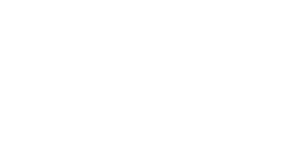

C:\Users\asuwa\anaconda3\envs\RadonNI\lib\site-packages\geopandas\plotting.py:634: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(


In [58]:
f, ax = plt.subplots(1, figsize=(8, 8));
ax = bedrocks.plot(axes=ax)
f.suptitle('Northern Ireland Bedrock Geology')
plt.show('UnitName')

<IPython.core.display.Javascript object>


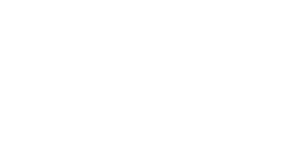

<AxesSubplot:>

In [59]:
bedrocks.plot(column='UnitName', edgecolor="black", cmap=None, legend=True, figsize=(20, 20))

In [60]:
bedrocks

,MSLINK_0,UnitName,Code,area,geometry
0,3678,ACID VOLCANICS,5,4.171498e+05,"POLYGON ((306027.195 353143.694, 306147.747 35..."
1,3678,ACID VOLCANICS,5,8.885223e+05,"POLYGON ((305968.411 353228.661, 306164.238 35..."
2,3659,ACID VOLCANICS,5,5.596615e+04,"POLYGON ((313527.461 407868.052, 313589.811 40..."
3,3663,ACID VOLCANICS,5,9.072705e+04,"POLYGON ((325888.569 386805.060, 325974.534 38..."
4,3659,ACID VOLCANICS,5,1.247527e+05,"POLYGON ((311478.844 406950.057, 311603.542 40..."
...,...,...,...,...,...
2258,3602,SANDSTONE,8,1.299333e+08,"POLYGON ((275379.821 345384.076, 275448.622 34..."
2259,3689,SANDSTONE,8,2.949386e+05,"POLYGON ((344783.212 372882.594, 344956.610 37..."
2260,3581,SANDSTONE,8,3.032128e+05,"POLYGON ((310257.133 438486.495, 310370.824 43..."
2261,0,SANDSTONE,8,1.311301e+01,"POLYGON ((262865.226 428766.507, 262868.173 42..."


In [61]:
bedrocks.crs

<Projected CRS: EPSG:29902>
Name: TM65 / Irish Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore.
- bounds: (-10.56, 51.39, -5.93, 55.43)
Coordinate Operation:
- name: Irish Grid
- method: Transverse Mercator
Datum: TM65
- Ellipsoid: Airy Modified 1849
- Prime Meridian: Greenwich

In [62]:
bedrocks['UnitName'].value_counts() # number of polygons of each bedrock type

LIMESTONE                 492
MUDSTONE                  490
SANDSTONE                 346
BASALT                    343
GRANITE                   184
LITHIC ARENITE            174
PSAMMITE & Semi-Pelite    139
CONGLOMERATE               41
ACID VOLCANICS             24
ANDESITE                   18
GABBRO                     12
Name: UnitName, dtype: int64

In [63]:
bedrocks['UnitName'].value_counts(normalize=True)

LIMESTONE                 0.217411
MUDSTONE                  0.216527
SANDSTONE                 0.152894
BASALT                    0.151569
GRANITE                   0.081308
LITHIC ARENITE            0.076889
PSAMMITE & Semi-Pelite    0.061423
CONGLOMERATE              0.018118
ACID VOLCANICS            0.010605
ANDESITE                  0.007954
GABBRO                    0.005303
Name: UnitName, dtype: float64

In [64]:
bedrocks['UnitName'].describe()

count          2263
unique           11
top       LIMESTONE
freq            492
Name: UnitName, dtype: object

In [65]:
radon_bedrock_counties = gpd.sjoin(bedrocks, radon_counties, how='inner', lsuffix='left', rsuffix='right') 

In [66]:
radon_bedrock_counties

,MSLINK_0,UnitName,Code,area,geometry,index_right,COUNTY_ID,CountyName,Area_SqKM,OBJECTID,index_righ,Tile,class,x,y
1,3678,ACID VOLCANICS,5,8.885223e+05,"POLYGON ((305968.411 353228.661, 306164.238 35...",13760,3,DOWN,2491.238606,6,10307,J0652,1,306500,352500
1,3678,ACID VOLCANICS,5,8.885223e+05,"POLYGON ((305968.411 353228.661, 306164.238 35...",13634,3,DOWN,2491.238606,6,10134,J0653,4,306500,353500
3,3663,ACID VOLCANICS,5,9.072705e+04,"POLYGON ((325888.569 386805.060, 325974.534 38...",4223,1,ANTRIM,3097.847750,2,5275,J2586,1,325500,386500
4,3659,ACID VOLCANICS,5,1.247527e+05,"POLYGON ((311478.844 406950.057, 311603.542 40...",5146,1,ANTRIM,3097.847750,2,2897,D1106,1,311500,406500
9,3659,ACID VOLCANICS,5,9.223958e+05,"POLYGON ((319385.996 357532.585, 319634.394 35...",13678,3,DOWN,2491.238606,6,9453,J1957,1,319500,357500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,3602,SANDSTONE,8,1.299333e+08,"POLYGON ((275379.821 345384.076, 275448.622 34...",84,6,TYRONE,3265.796622,1,10107,H7953,2,279500,353500
2258,3602,SANDSTONE,8,1.299333e+08,"POLYGON ((275379.821 345384.076, 275448.622 34...",152,6,TYRONE,3265.796622,1,10109,H8153,2,281500,353500
2258,3602,SANDSTONE,8,1.299333e+08,"POLYGON ((275379.821 345384.076, 275448.622 34...",151,6,TYRONE,3265.796622,1,10108,H8053,2,280500,353500
2258,3602,SANDSTONE,8,1.299333e+08,"POLYGON ((275379.821 345384.076, 275448.622 34...",154,6,TYRONE,3265.796622,1,9935,H8054,2,280500,354500


In [67]:
# subset the data, i.e. create a new dataset representing the radon distribution in the County Tyrone
radon_bedrock_tyrone = radon_bedrock_counties[radon_bedrock_counties.CountyName == "TYRONE"]
len(radon_bedrock_counties) # returns the number of radon data (data count) in county Tyrone

13456

In [68]:
radon_bedrock_tyrone.to_file('data_files/radon_bedrock.shp')

<ipython-input-68-c1216b5834e7>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  radon_bedrock_tyrone.to_file('data_files/radon_bedrock.shp')


In [69]:
radon_bedrock_tyrone.crs

<Projected CRS: EPSG:29902>
Name: TM65 / Irish Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Ireland - onshore.
- bounds: (-10.56, 51.39, -5.93, 55.43)
Coordinate Operation:
- name: Irish Grid
- method: Transverse Mercator
Datum: TM65
- Ellipsoid: Airy Modified 1849
- Prime Meridian: Greenwich

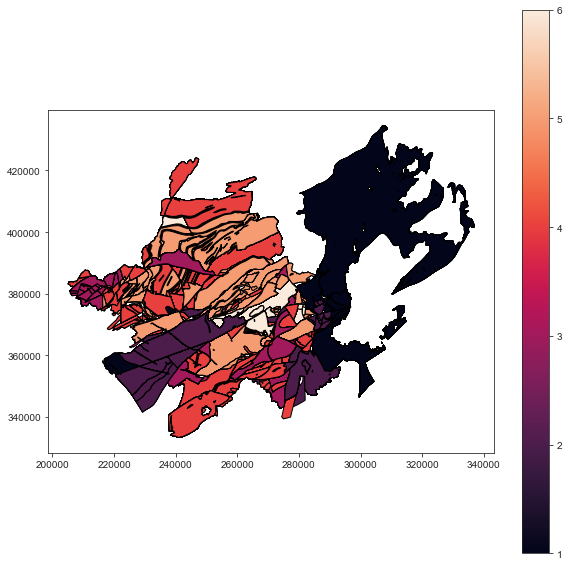

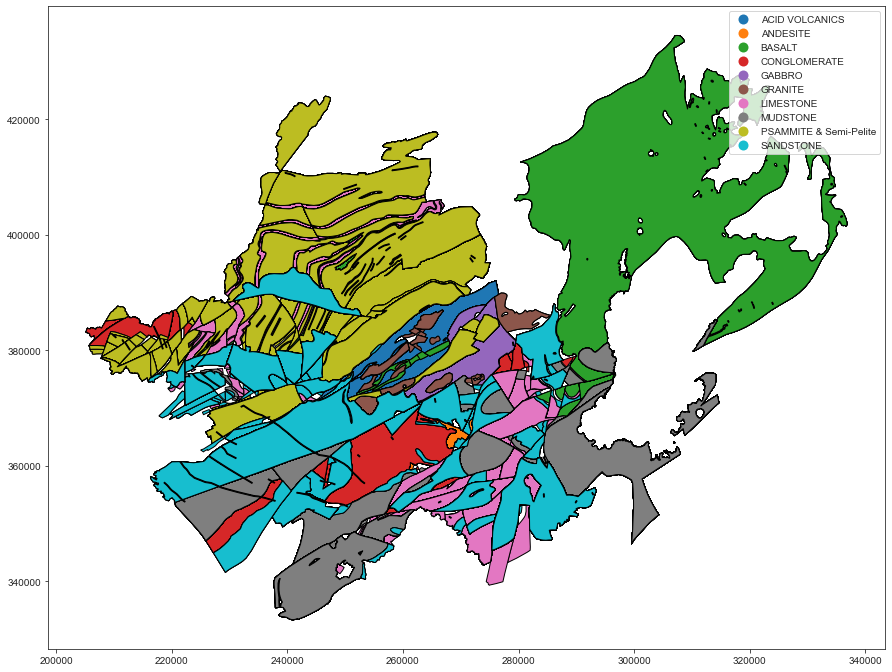

In [70]:
%matplotlib inline
radon_bedrock_tyrone.plot(column='class', cmap=None, legend=True, figsize=(10, 10), edgecolor="black");
radon_bedrock_tyrone.plot(column='UnitName', cmap=None, legend=True, figsize=(15, 15), edgecolor="black");

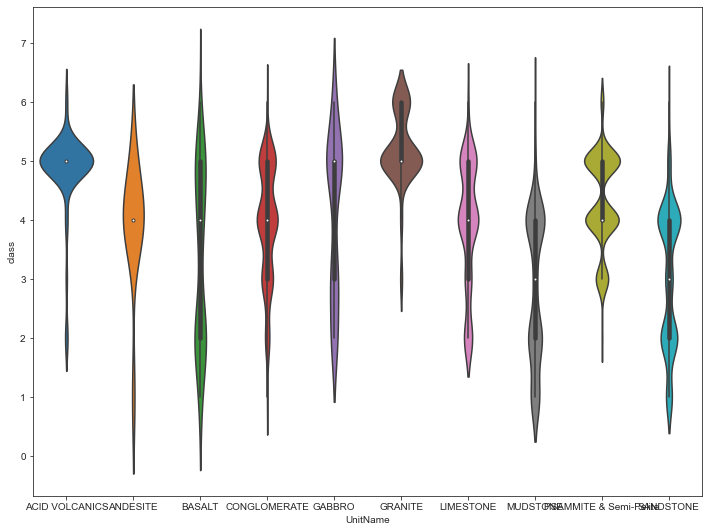

In [71]:
# distribution of various classes within the counties. Every county contian the 6 classess, except County LONDONDERRY
# adapted from: https://stackoverflow.com/questions/31594549/how-do-i-change-the-figure-size-for-a-seaborn-plot
sns.set_style('ticks')
fig, ax = plt.subplots()
# set the size of the graph
fig.set_size_inches(12, 9)
sns.violinplot(x = "UnitName", y = "class", data = radon_bedrock_tyrone)
#save the figure as an image
fig.savefig('radon_bedrock_tyrone.png')